<a href="https://colab.research.google.com/github/AllanKamimura/xmobots/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
# util libraries
!git clone -q http://github.com/AllanKamimura/utils.git
!git clone -q https://github.com/LinShanify/HeatMap.git
from utils.myutils import *
from HeatMap import HeatMap

!pip install tensorflow 
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
from google.colab import drive
drive.mount('/content/drive')

# upload Data.zip and unzip
path_to_data = ""
!unzip $path_to_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Estagios/xmobots/Data.zip
replace Data/0000_soil.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# pre-processing

In [3]:
# load images path
file_list = glob("./Data/*.png")

df_path = pd.DataFrame({"path": file_list})
df_path.head()

,path
0,./Data/5931_soil.png
1,./Data/3503_tree.png
2,./Data/2828_tree.png
3,./Data/1427_soil.png
4,./Data/6128_soil.png


,path,label_bin,label
0,./Data/5931_soil.png,0,soil
1,./Data/3503_tree.png,1,tree
2,./Data/2828_tree.png,1,tree
3,./Data/1427_soil.png,0,soil
4,./Data/6128_soil.png,0,soil


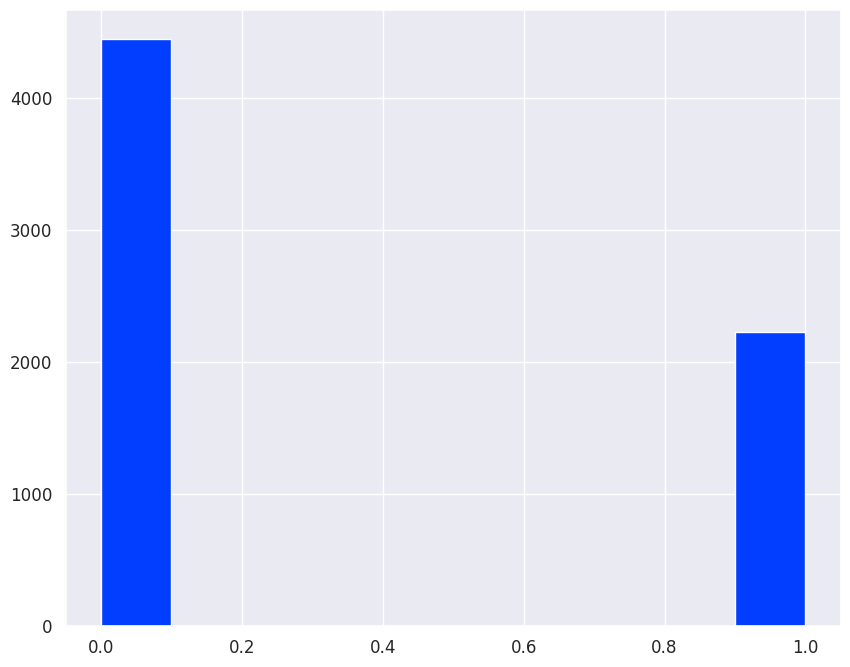

In [4]:
# create labels
df_path["label_bin"] = df_path["path"].str.contains("tree") * 1
df_path["label"]     = df_path["path"].str.split("_").str[-1].str.split(".").str[0]
df_path.label_bin.hist()
df_path.head()

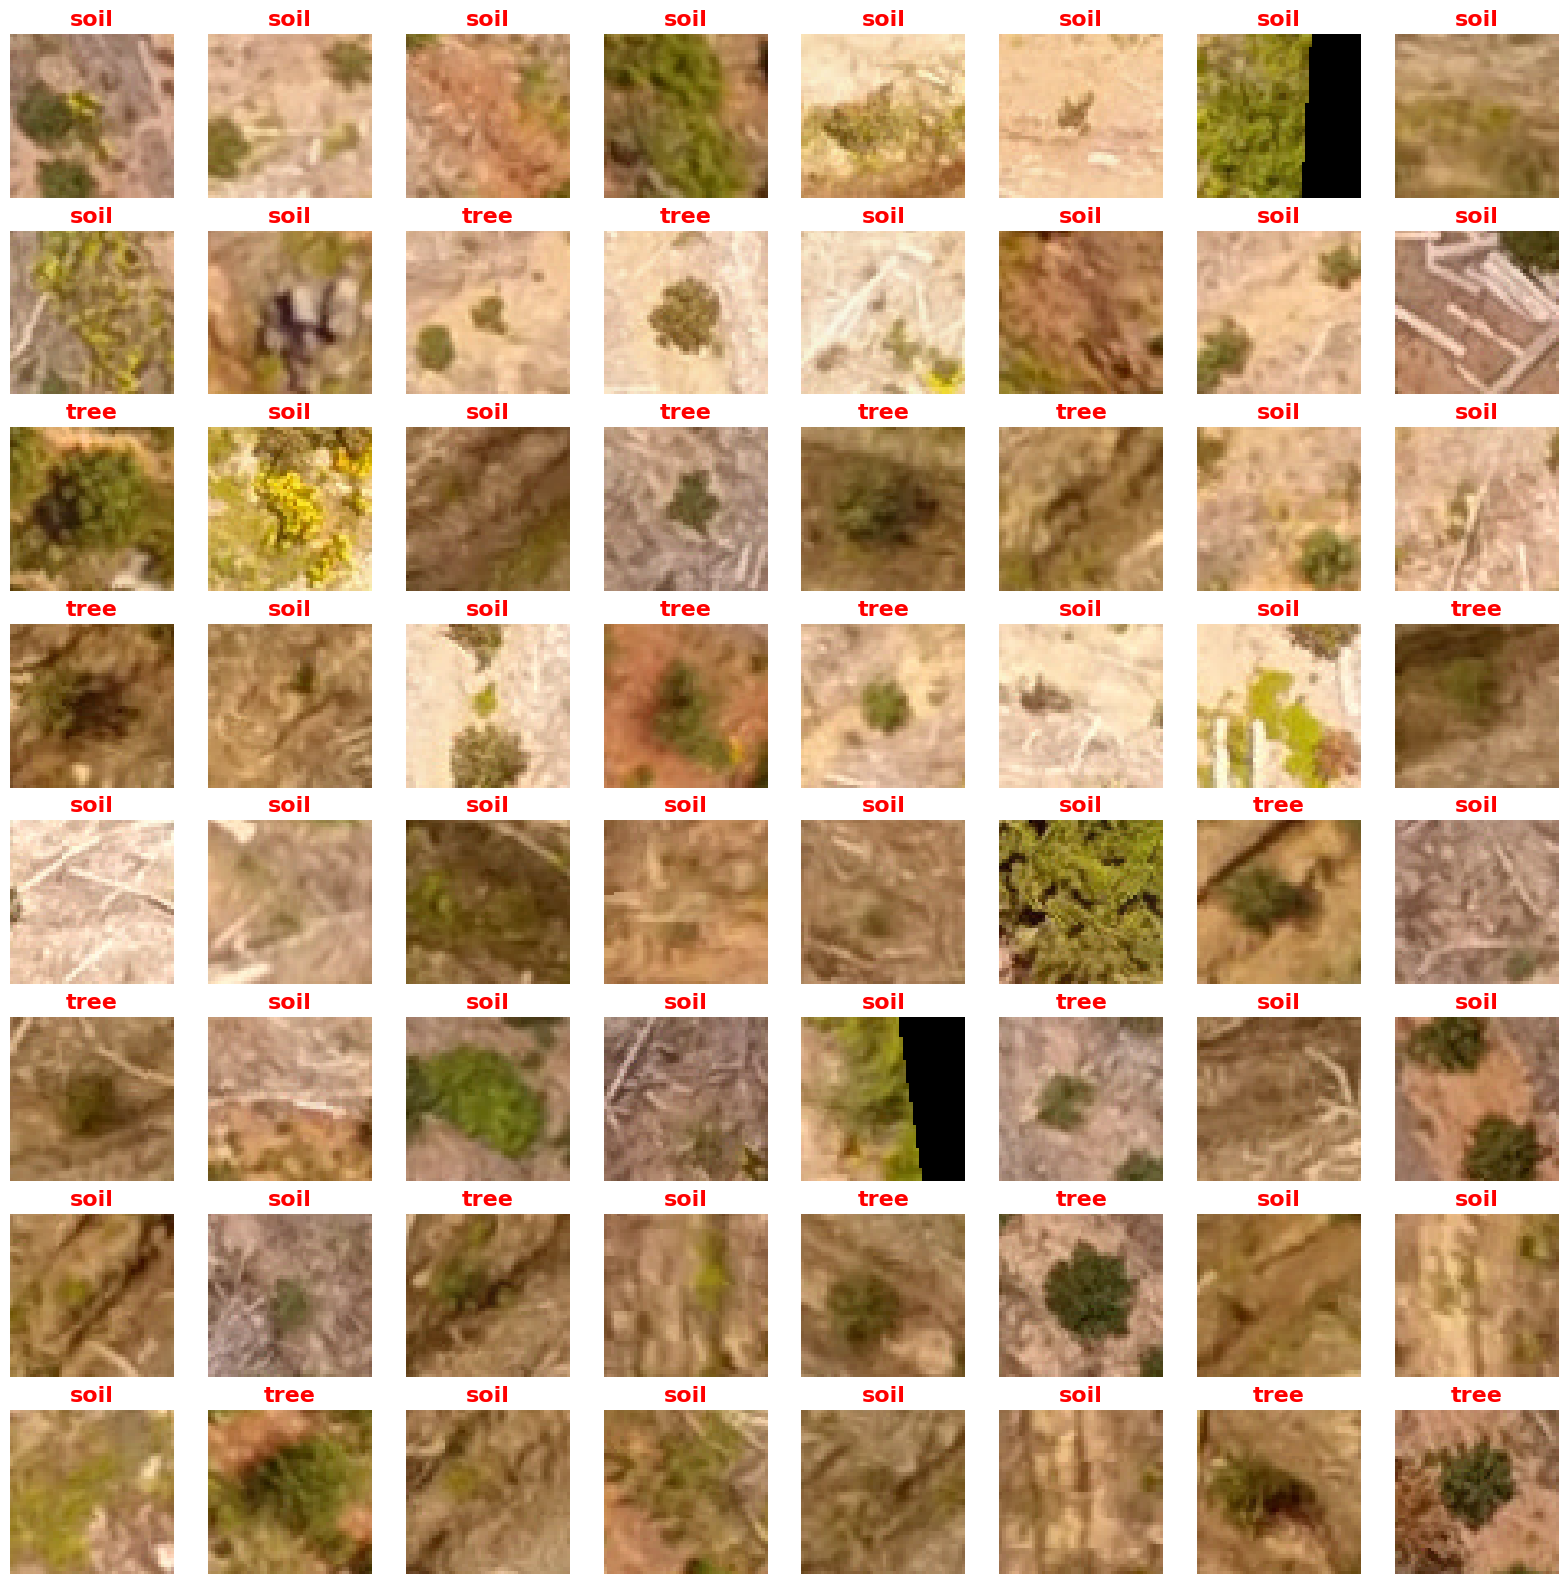

In [5]:
# check classes
n = 8
sample = df_path.sample(n*n)
fig = plt.figure(figsize = (20,20))
i = 0

for index, sample_row in sample.iterrows():
    image_path = sample_row.path
    label = sample_row.label

    image_arr = tf.keras.preprocessing.image.load_img(
        image_path
    )

    fig.add_subplot(n, n, i+1)
    i+=1
    plt.imshow(image_arr)
    plt.axis("off")
    plt.title(label, fontdict = {"fontsize": 16,
                                 "fontweight": "bold",
                                 "color": "red"})

In [6]:
# create datafeed with tensorflow
seed = 2
height, width = 50, 50

datagen = ImageDataGenerator(
    validation_split   = 0.2,  # validation split
    horizontal_flip    = True, # data augmentation
    vertical_flip      = True,
    rotation_range     = 5,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    # shear_range        = 1.0,
    zoom_range         = 0.1,
)

train_data = datagen.flow_from_dataframe(
    x_col = "path",
    y_col = "label",
    dataframe = df_path,
    target_size = (height, width),
    class_mode = "categorical",
    batch_size = 256,
    subset = "training",
    seed = seed, # keep train/valid split consistent
    shuffle = True,
)

valid_data = datagen.flow_from_dataframe(
    x_col = "path",
    y_col = "label",
    dataframe = df_path,
    target_size = (height, width),
    class_mode = "categorical",
    batch_size = 256,
    subset = "validation",
    seed = seed,
    shuffle = True,
)

print(valid_data.class_indices)

Found 5338 validated image filenames belonging to 2 classes.
Found 1334 validated image filenames belonging to 2 classes.
{'soil': 0, 'tree': 1}


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


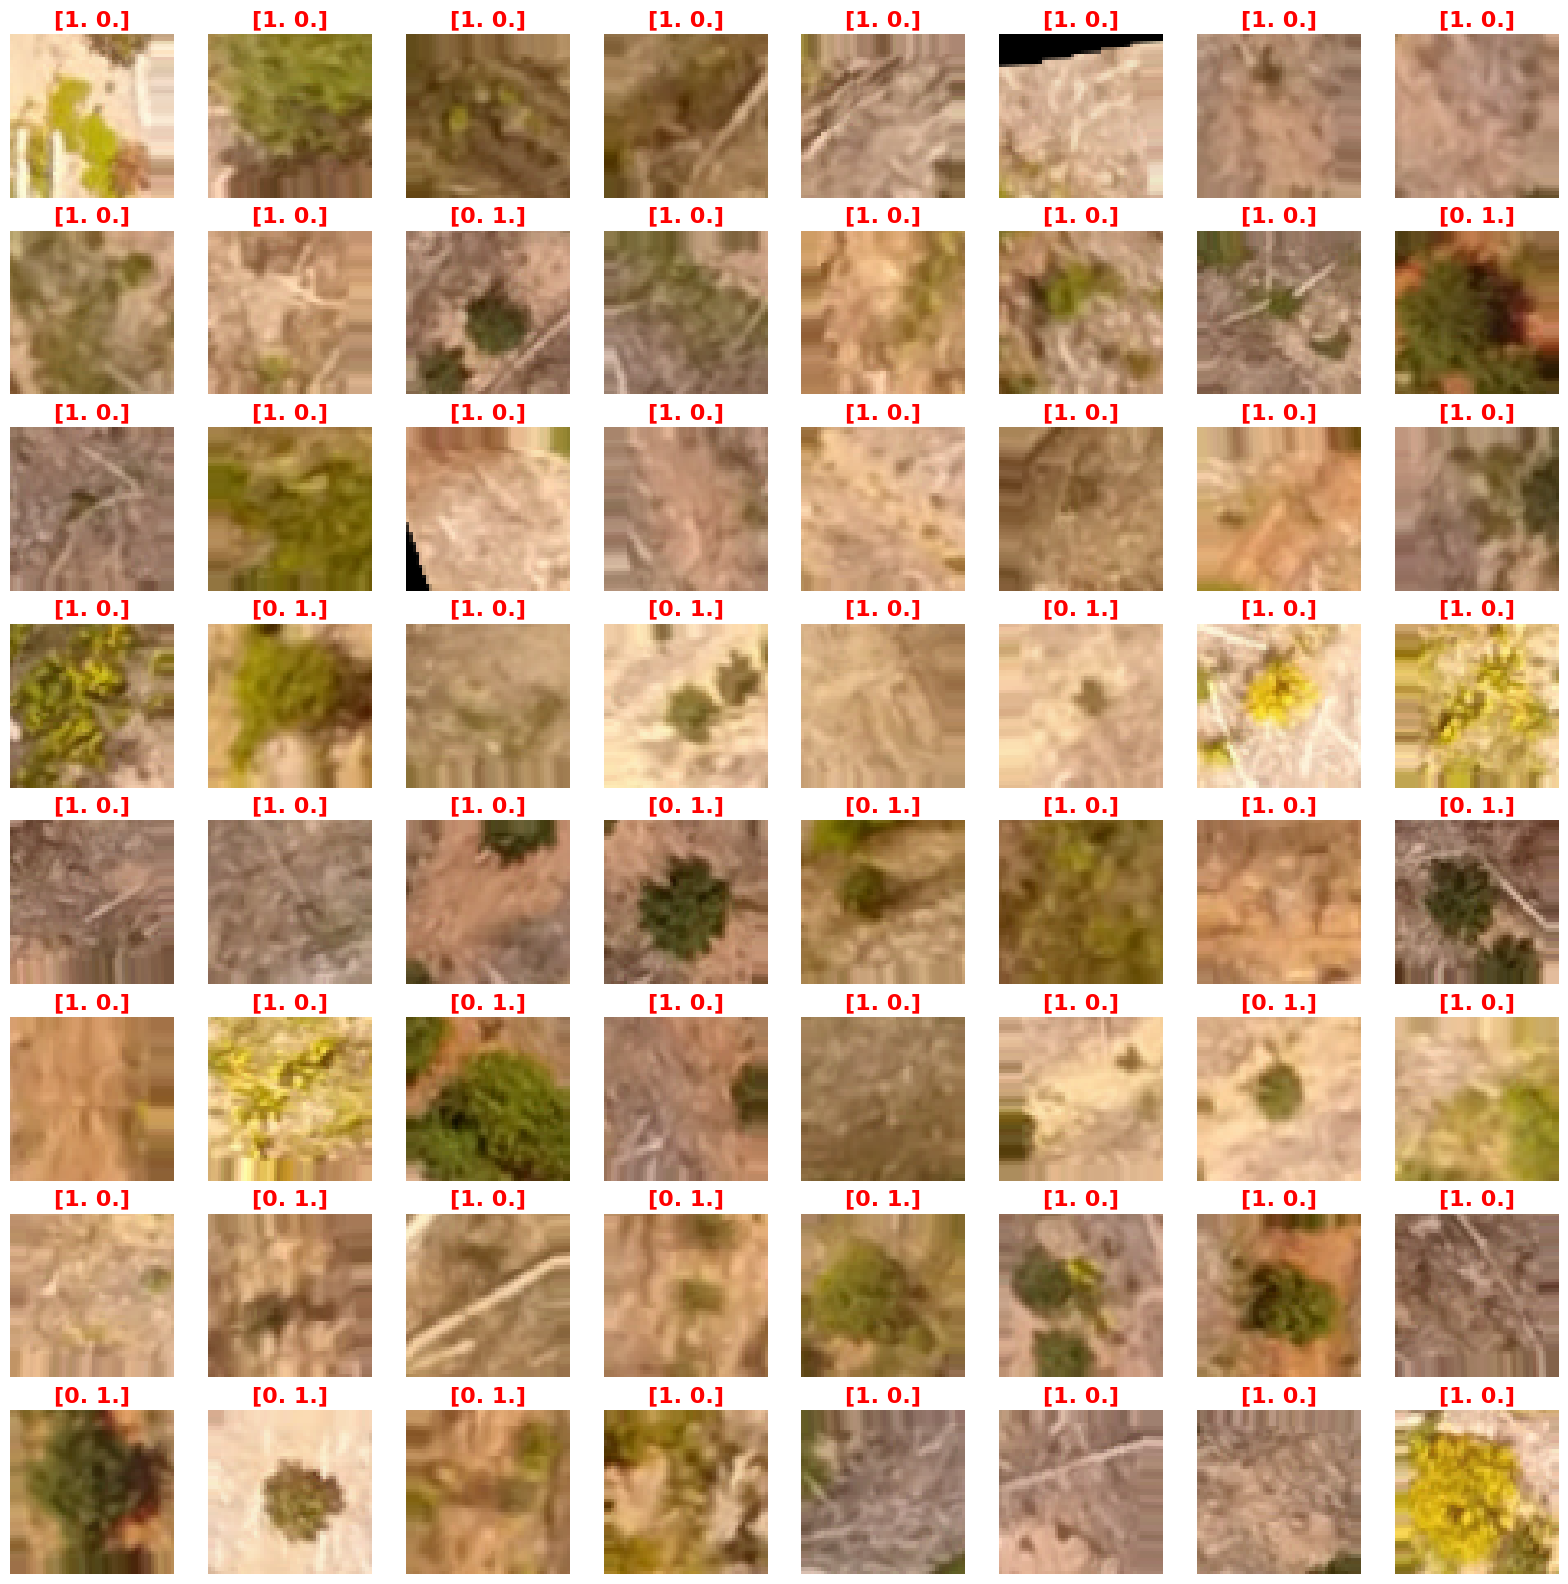

In [7]:
# check onehot enconding and augmentation
n = 8
fig = plt.figure(figsize = (20,20))
image_list, label_list = train_data.next()
image_list = image_list.astype("uint8")
for i in range(n*n):
    image_arr = image_list[i]
    label     = label_list[i]
    fig.add_subplot(n, n, i+1)
    plt.imshow(image_arr)
    plt.axis("off")
    plt.title(label, fontdict = {"fontsize": 16,
                                 "fontweight": "bold",
                                 "color": "red"})

# model

In [ ]:
def base_model(shape):
    # base model is a standard imagenet-pre-trained model
    input = tf.keras.layers.Input(shape = shape, name = "input_layer")
    
    mobile_model = tf.keras.applications.MobileNetV3Small(
        include_top = False,
        input_shape = shape,
        pooling = "avg",
        weights = "imagenet",
        dropout_rate = 0.1,
        )
    
    y = mobile_model(input)

    model = tf.keras.models.Model(
        inputs = input,
        outputs = y,
        name = "mobile_average")  
    return model                 

def my_model(n_class):
    # base model is a standard fully-connected-layer model for classification
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 512, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 256, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = 128, activation = "relu", kernel_initializer = 'he_uniform'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units = n_class, activation = "softmax")
    ], name = "my_dense")
    return model

n_class = len(train_data.class_indices.keys())

conv_model = base_model(shape = (height,width,3))
fc_model = my_model(n_class = n_class)

conv_model.trainable = False # freeze the earlier layers of the model
model = tf.keras.models.Sequential([conv_model, fc_model], name = "my_model")

model.summary()                              

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_average (Functional)  (None, 576)              939120    
                                                                 
 my_dense (Sequential)       (None, 2)                 463490    
                                                                 
Total params: 1,402,610
Trainable params: 461,698
Non-trainable params: 940,912
_________________________________________________________________


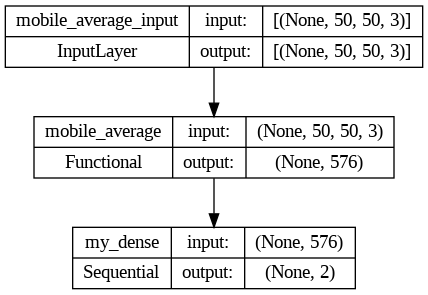

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(
        tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 9e-5, decay_steps = 500, decay_rate = 0.9
    )),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    # loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ["accuracy", 
               tfa.metrics.F1Score(threshold = 0.40, name = "f1_040", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.45, name = "f1_045", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.50, name = "f1_050", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.55, name = "f1_055", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.60, name = "f1_060", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.65, name = "f1_065", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.70, name = "f1_070", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.75, name = "f1_075", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.80, name = "f1_080", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.85, name = "f1_085", num_classes = n_class), 
               tfa.metrics.F1Score(threshold = 0.90, name = "f1_090", num_classes = n_class), 
               tf.keras.metrics.Recall(), 
               tf.keras.metrics.Precision()]
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            patience = 10, 
                                            restore_best_weights = True)

history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = 100,
                    callbacks = [callback],
                    class_weight = {0: 0.33, 1: 0.66} # to use with categorical
                    )   

Epoch 1/100
21/21 [==============================] - 27s 901ms/step - loss: 0.3304 - accuracy: 0.6398 - f1_040: 0.6497 - f1_045: 0.6370 - f1_050: 0.6265 - f1_055: 0.6139 - f1_060: 0.5979 - f1_065: 0.5794 - f1_070: 0.5473 - f1_075: 0.5084 - f1_080: 0.4669 - f1_085: 0.4046 - f1_090: 0.3200 - recall_3: 0.6398 - precision_3: 0.6398 - val_loss: 0.4550 - val_accuracy: 0.8306 - val_f1_040: 0.7866 - val_f1_045: 0.8071 - val_f1_050: 0.8047 - val_f1_055: 0.7910 - val_f1_060: 0.7465 - val_f1_065: 0.6905 - val_f1_070: 0.6274 - val_f1_075: 0.5220 - val_f1_080: 0.3892 - val_f1_085: 0.2505 - val_f1_090: 0.1203 - val_recall_3: 0.8306 - val_precision_3: 0.8306
Epoch 2/100
21/21 [==============================] - 18s 861ms/step - loss: 0.2543 - accuracy: 0.7207 - f1_040: 0.7217 - f1_045: 0.7166 - f1_050: 0.7080 - f1_055: 0.7005 - f1_060: 0.6880 - f1_065: 0.6760 - f1_070: 0.6536 - f1_075: 0.6241 - f1_080: 0.5843 - f1_085: 0.5400 - f1_090: 0.4589 - recall_3: 0.7207 - precision_3: 0.7207 - val_loss: 0.4064

In [ ]:
history.history['val_f1_055']

[array([0.8563, 0.7256], dtype=float32),
 array([0.8576, 0.7485], dtype=float32),
 array([0.8773, 0.7664], dtype=float32),
 array([0.8933, 0.7834], dtype=float32),
 array([0.8951, 0.7902], dtype=float32),
 array([0.9035, 0.8064], dtype=float32),
 array([0.9137, 0.8213], dtype=float32),
 array([0.8981, 0.8153], dtype=float32),
 array([0.901 , 0.8176], dtype=float32),
 array([0.9031, 0.8322], dtype=float32),
 array([0.9015, 0.8166], dtype=float32),
 array([0.9143, 0.8319], dtype=float32),
 array([0.912 , 0.8234], dtype=float32),
 array([0.9043, 0.8217], dtype=float32),
 array([0.916 , 0.8407], dtype=float32),
 array([0.9191, 0.8407], dtype=float32),
 array([0.9118, 0.8319], dtype=float32),
 array([0.9262, 0.8486], dtype=float32),
 array([0.9164, 0.8265], dtype=float32),
 array([0.9226, 0.8395], dtype=float32),
 array([0.9202, 0.8443], dtype=float32),
 array([0.9245, 0.8585], dtype=float32),
 array([0.9228, 0.8513], dtype=float32),
 array([0.9197, 0.8458], dtype=float32),
 array([0.9178, 

In [ ]:
# unfreeze earlier layers and fine-tune
conv_model.trainable = True
model.summary()
model.optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 5e-6, decay_steps = 500, decay_rate = 0.9
    ))

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobile_average (Functional)  (None, 576)              939120    
                                                                 
 my_dense (Sequential)       (None, 2)                 463490    
                                                                 
Total params: 1,402,610
Trainable params: 1,388,706
Non-trainable params: 13,904
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            patience = 15, 
                                            restore_best_weights = True)

history2 = model.fit(train_data,
                     validation_data = valid_data,
                     epochs = 100,
                     callbacks = [callback],
                     class_weight = {0: 0.33, 1: 0.66}
                     )   

Epoch 1/100
21/21 [==============================] - 15s 741ms/step - loss: 0.1270 - accuracy: 0.8773 - f1_040: 0.8678 - f1_045: 0.8681 - f1_050: 0.8661 - f1_055: 0.8672 - f1_060: 0.8660 - f1_065: 0.8620 - f1_070: 0.8534 - f1_075: 0.8433 - f1_080: 0.8271 - f1_085: 0.8039 - f1_090: 0.7669 - recall_3: 0.8773 - precision_3: 0.8773 - val_loss: 0.2314 - val_accuracy: 0.9138 - val_f1_040: 0.8967 - val_f1_045: 0.9008 - val_f1_050: 0.9007 - val_f1_055: 0.9009 - val_f1_060: 0.8939 - val_f1_065: 0.8850 - val_f1_070: 0.8769 - val_f1_075: 0.8631 - val_f1_080: 0.8500 - val_f1_085: 0.8319 - val_f1_090: 0.7972 - val_recall_3: 0.9138 - val_precision_3: 0.9138
Epoch 2/100
21/21 [==============================] - 16s 746ms/step - loss: 0.1324 - accuracy: 0.8767 - f1_040: 0.8659 - f1_045: 0.8660 - f1_050: 0.8657 - f1_055: 0.8649 - f1_060: 0.8633 - f1_065: 0.8554 - f1_070: 0.8495 - f1_075: 0.8396 - f1_080: 0.8260 - f1_085: 0.8027 - f1_090: 0.7642 - recall_3: 0.8767 - precision_3: 0.8767 - val_loss: 0.2208

In [ ]:
history2.history['val_f1_060']

[array([0.9282, 0.8596], dtype=float32),
 array([0.9269, 0.867 ], dtype=float32),
 array([0.9202, 0.8564], dtype=float32),
 array([0.9126, 0.8369], dtype=float32),
 array([0.9197, 0.8537], dtype=float32),
 array([0.9165, 0.8565], dtype=float32),
 array([0.9207, 0.8613], dtype=float32),
 array([0.9309, 0.8676], dtype=float32),
 array([0.9153, 0.8519], dtype=float32),
 array([0.9156, 0.8506], dtype=float32),
 array([0.9166, 0.8554], dtype=float32),
 array([0.9163, 0.845 ], dtype=float32),
 array([0.9278, 0.886 ], dtype=float32),
 array([0.914 , 0.8589], dtype=float32),
 array([0.9244, 0.869 ], dtype=float32),
 array([0.916 , 0.8753], dtype=float32),
 array([0.9322, 0.8645], dtype=float32),
 array([0.9197, 0.8702], dtype=float32),
 array([0.9251, 0.8674], dtype=float32),
 array([0.9241, 0.8683], dtype=float32),
 array([0.9246, 0.864 ], dtype=float32),
 array([0.9208, 0.8627], dtype=float32),
 array([0.9245, 0.8732], dtype=float32),
 array([0.9183, 0.8647], dtype=float32),
 array([0.936 , 

## evaluate

Text(0.5, 1.0, 'tree f1_score per epoch, color = threshold')

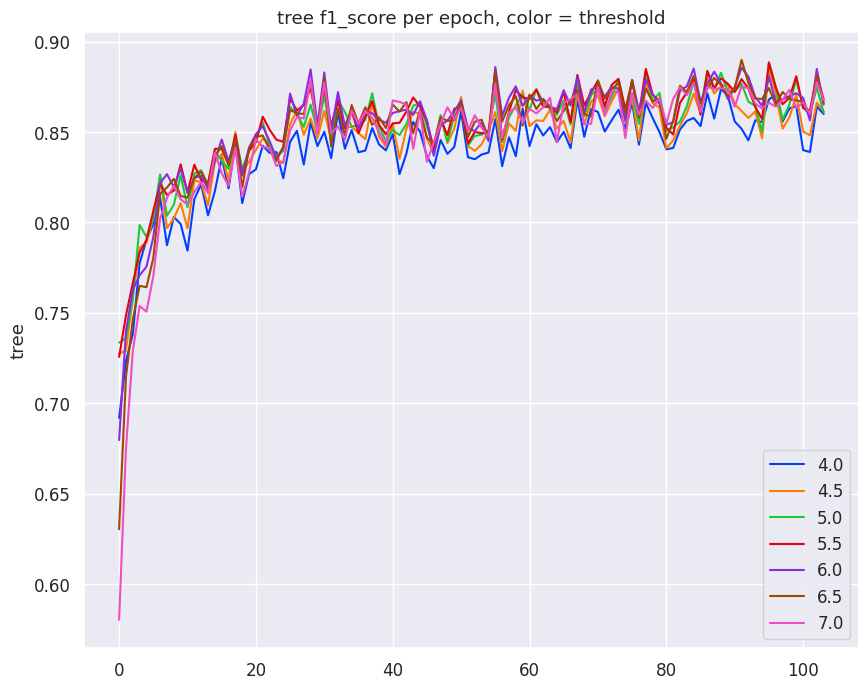

In [ ]:
for thresh in [str(i).zfill(3) for i in range(40,75,5)]:
    hist_df = pd.DataFrame(history.history[f'val_f1_{thresh}'] + history2.history[f'val_f1_{thresh}'], columns = ["soil", "tree"])
    sns.lineplot(hist_df["tree"], label  = float(thresh)/10)
plt.title("tree f1_score per epoch, color = threshold")

Text(0.5, 1.0, 'weighted f1_Score per epoch, color = class')

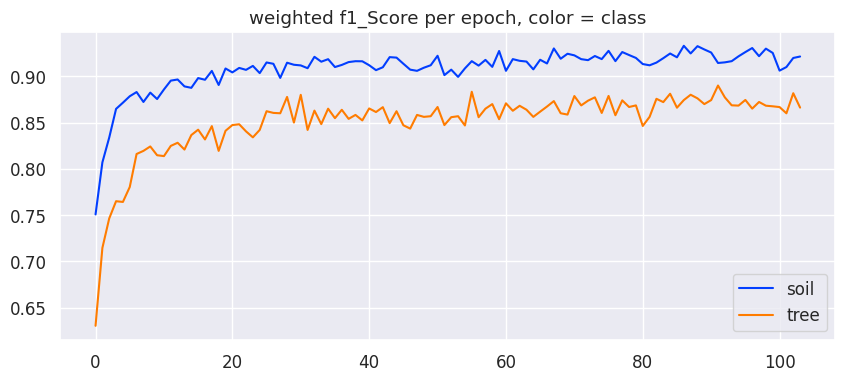

In [ ]:
hist_df = pd.DataFrame(history.history['val_f1_065'] + history2.history['val_f1_065'], columns = ["soil", "tree"])
hist_df.plot(figsize = (10, 4))
plt.title("weighted f1_Score per epoch, color = class")

In [ ]:
model.evaluate(train_data)

21/21 [==============================] - 13s 603ms/step - loss: 0.2017 - accuracy: 0.9204 - f1_040: 0.9099 - f1_045: 0.9121 - f1_050: 0.9116 - f1_055: 0.9115 - f1_060: 0.9074 - f1_065: 0.9042 - f1_070: 0.8991 - f1_075: 0.8885 - f1_080: 0.8757 - f1_085: 0.8566 - f1_090: 0.8217 - recall_3: 0.9204 - precision_3: 0.9204


[0.20168855786323547,
 0.9203821420669556,
 array([0.9416, 0.8783], dtype=float32),
 array([0.9421, 0.8821], dtype=float32),
 array([0.9394, 0.8838], dtype=float32),
 array([0.9371, 0.886 ], dtype=float32),
 array([0.9328, 0.882 ], dtype=float32),
 array([0.9263, 0.8821], dtype=float32),
 array([0.9184, 0.8798], dtype=float32),
 array([0.9035, 0.8735], dtype=float32),
 array([0.8869, 0.8645], dtype=float32),
 array([0.8641, 0.8491], dtype=float32),
 array([0.8201, 0.8234], dtype=float32),
 0.9203821420669556,
 0.9203821420669556]

In [ ]:
model.evaluate(valid_data)

6/6 [==============================] - 5s 396ms/step - loss: 0.2360 - accuracy: 0.9100 - f1_040: 0.8919 - f1_045: 0.8930 - f1_050: 0.8965 - f1_055: 0.8940 - f1_060: 0.8894 - f1_065: 0.8867 - f1_070: 0.8771 - f1_075: 0.8692 - f1_080: 0.8599 - f1_085: 0.8383 - f1_090: 0.8069 - recall_3: 0.9100 - precision_3: 0.9100


[0.23595155775547028,
 0.9100449681282043,
 array([0.9356, 0.8481], dtype=float32),
 array([0.9368, 0.8493], dtype=float32),
 array([0.9339, 0.8592], dtype=float32),
 array([0.9272, 0.8609], dtype=float32),
 array([0.9241, 0.8547], dtype=float32),
 array([0.9165, 0.8568], dtype=float32),
 array([0.905 , 0.8491], dtype=float32),
 array([0.8945, 0.844 ], dtype=float32),
 array([0.8824, 0.8373], dtype=float32),
 array([0.8489, 0.8277], dtype=float32),
 array([0.8121, 0.8017], dtype=float32),
 0.9100449681282043,
 0.9100449681282043]

In [ ]:
# put above results into a table
np.savetxt("dummy",
    np.array([  
 np.array([0.9471, 0.8734], dtype=np.float32),
 np.array([0.9455, 0.8711], dtype=np.float32),
 np.array([0.9418, 0.8747], dtype=np.float32),
 np.array([0.9386, 0.8798], dtype=np.float32),
 np.array([0.938 , 0.8796], dtype=np.float32),
 np.array([0.9299, 0.8724], dtype=np.float32),
 np.array([0.9235, 0.8597], dtype=np.float32),
 np.array([0.9139, 0.8538], dtype=np.float32),
 np.array([0.8928, 0.8443], dtype=np.float32),
 np.array([0.8564, 0.8247], dtype=np.float32),
 np.array([0.8168, 0.8129], dtype=np.float32)]).T,
    delimiter = ",")

x = pd.read_csv("./dummy", names = [i/100 for i in range(40,95,5)])
x.index = ["soil", "tree"]
x.head()

,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90
soil,0.9471,0.9455,0.9418,0.9386,0.9380,0.9299,0.9235,0.9139,0.8928,0.8564,0.8168
tree,0.8734,0.8711,0.8747,0.8798,0.8796,0.8724,0.8597,0.8538,0.8443,0.8247,0.8129


8/8 [==============================] - 0s 41ms/step


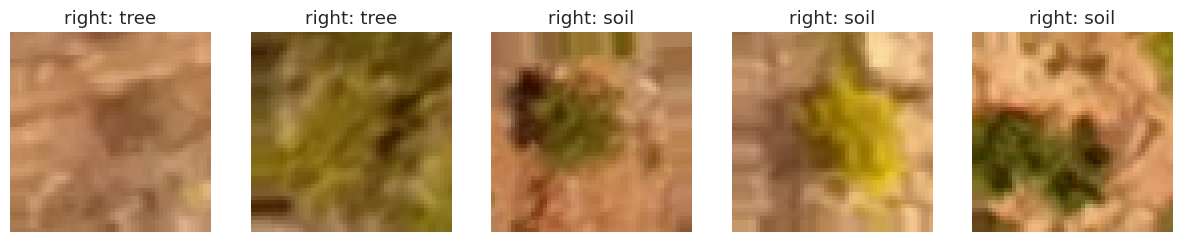

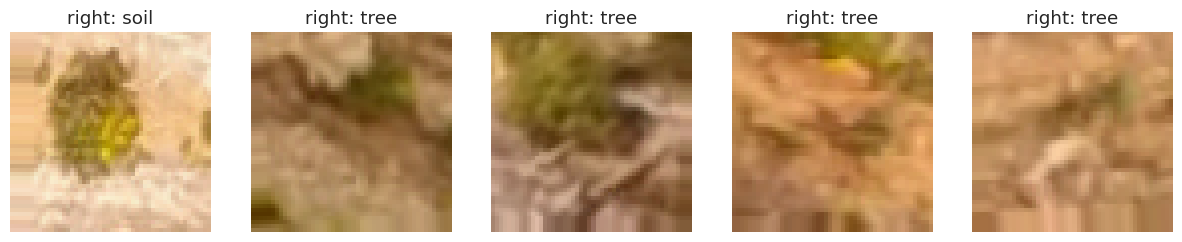

<Figure size 1500x300 with 0 Axes>

In [ ]:
# wrong predicts
images, labels = valid_data.next()

y_pred = model.predict(images)
wrong_predict = images[np.argmax(y_pred, axis = 1) != np.argmax(labels, axis = 1)]
right_labels  = labels[np.argmax(y_pred, axis = 1) != np.argmax(labels, axis = 1)]

class_dict = {0: "soil", 1: "tree"}
fig = plt.figure(figsize = (15, 3))
for i, wrong_image in enumerate(wrong_predict):
    fig.add_subplot(1, 5, (i%5)+1)
    plt.imshow(wrong_image.astype("uint8"))
    plt.title(f"right: {class_dict[np.argmax(right_labels[i])]}")
    plt.grid("off")
    plt.axis("off")
    if (i%5) == 4:
        plt.show()
        fig = plt.figure(figsize = (15, 3))


In [ ]:
save_path = ""
model.save(save_path)

# Activation map

In [8]:
save_path = ""
model = tf.keras.models.load_model(save_path)

8/8 [==============================] - 0s 21ms/step


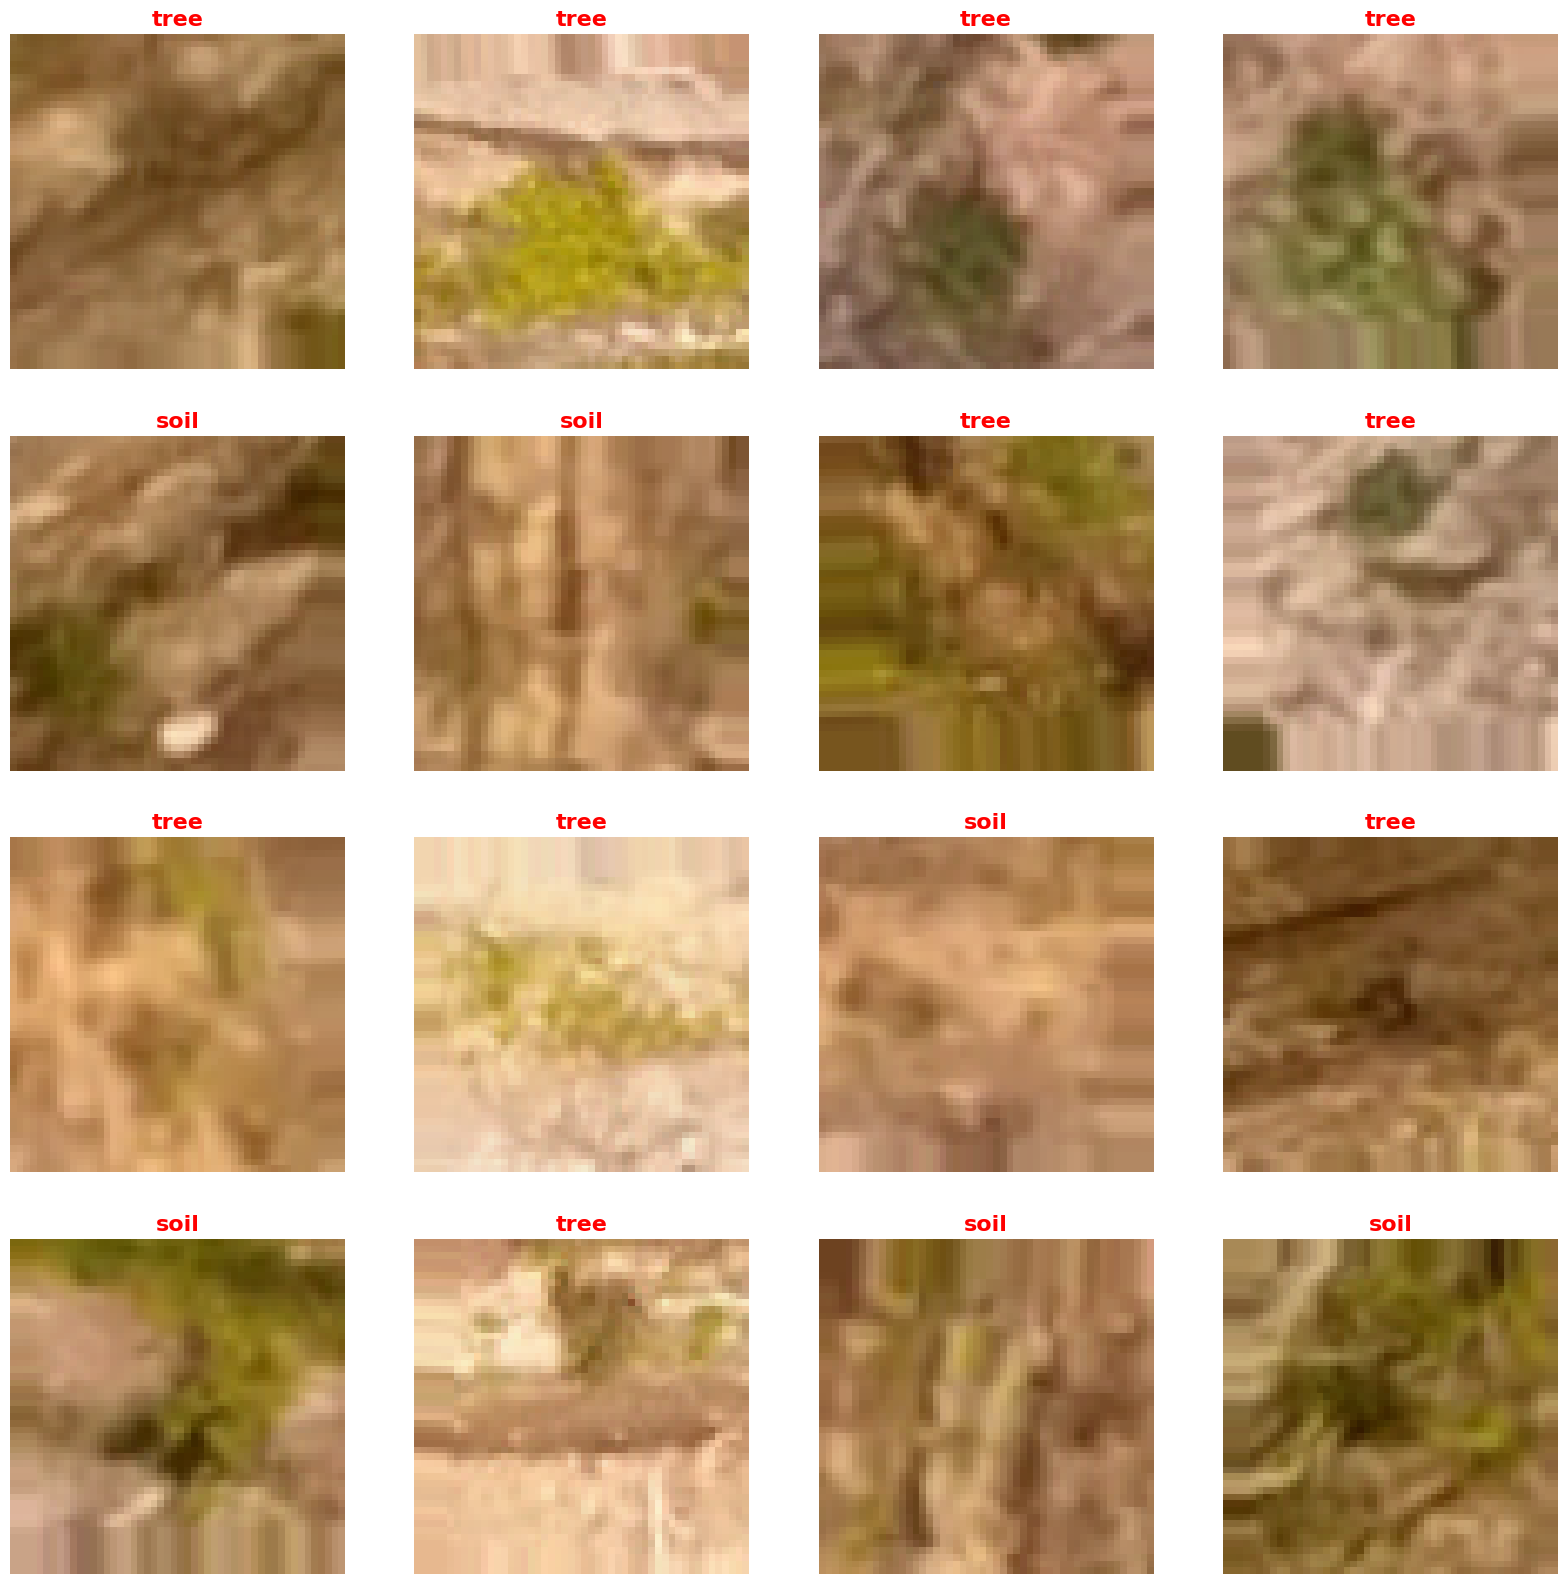

In [11]:
# wrong predicts
images, labels = valid_data.next()

y_pred = model.predict(images)
wrong_predict = images[np.argmax(y_pred, axis = 1) != np.argmax(labels, axis = 1)]
right_labels  = labels[np.argmax(y_pred, axis = 1) != np.argmax(labels, axis = 1)]

# check onehot enconding and augmentation
n = 4
fig = plt.figure(figsize = (20,20))
translate = {0: "soil", 1: "tree"}
for i in range(n*n):
    image_arr = wrong_predict[i].astype("uint8")
    label     = translate[np.argmax(right_labels[i]).astype("int")]
    fig.add_subplot(n, n, i+1)
    plt.imshow(image_arr)
    plt.axis("off")
    plt.title(label, fontdict = {"fontsize": 16,
                                 "fontweight": "bold",
                                 "color": "red"})

In [ ]:
# feature extractor, for details on how to navigate the model
# please, refer to:
## paper          -> https://arxiv.org/pdf/1905.02244v5.pdf
## implementation -> https://github.com/xiaolai-sqlai/mobilenetv3/blob/adc0ca87e1dd8136cd000ae81869934060171689/mobilenetv3

y = model.layers[0].layers[1].layers[1](wrong_predict)# rescale
y = model.layers[0].layers[1].layers[2](y)            # conv2D
y1 = model.layers[0].layers[1].layers[3](y)           # Batch Normalization
y = model.layers[0].layers[1].layers[4](y1, 3)        # hswish
y = model.layers[0].layers[1].layers[5](y)            # relu
y2 = model.layers[0].layers[1].layers[6](y, 1/6)      # hswish
y = model.layers[0].layers[1].layers[7]([y1, y2])     # multiplication
y = model.layers[0].layers[1].layers[8](y)            # zero-pad
y = model.layers[0].layers[1].layers[9](y)            # depth-wise
y = model.layers[0].layers[1].layers[10](y)           # Batch Normalization
ya = model.layers[0].layers[1].layers[11](y)          # Relu
yf = model.layers[0].layers[1].layers[12](ya)         # Global Average Pooling

In [ ]:
np.where(np.argmax(y_pred, axis = 1) != np.argmax(labels, axis = 1))

(array([ 23,  43,  63, 123, 126, 144, 147, 153, 177, 206]),)

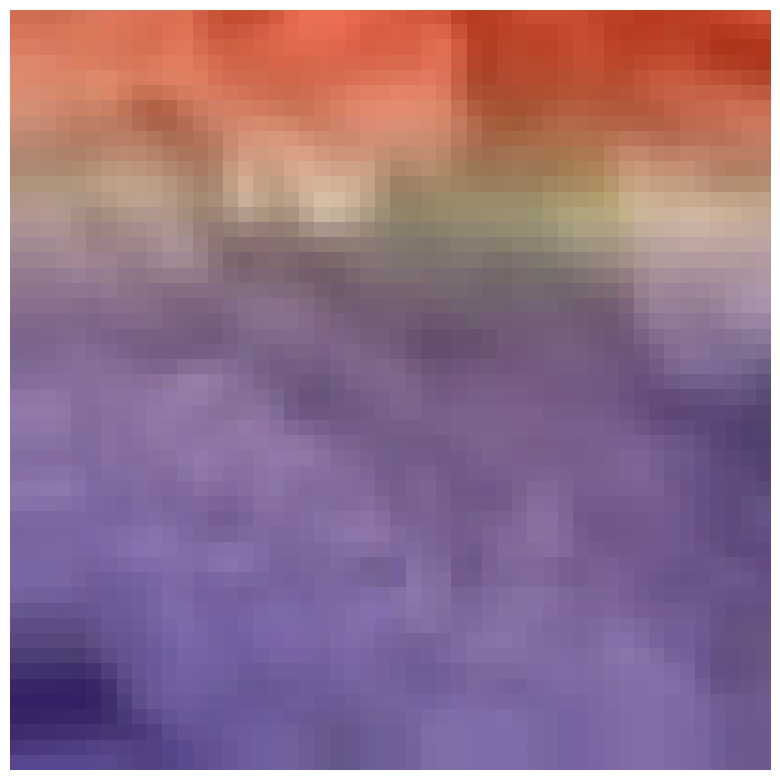

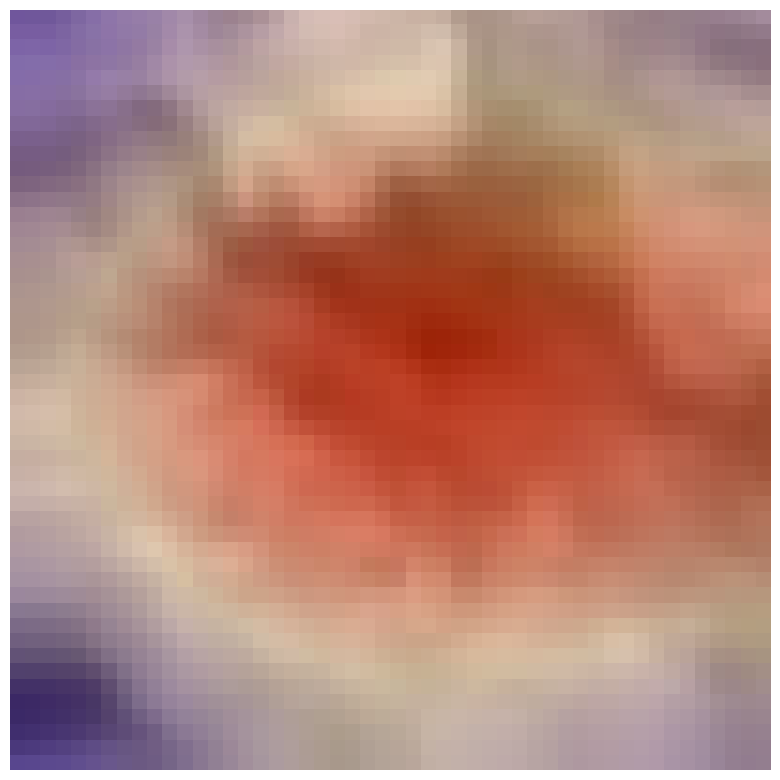

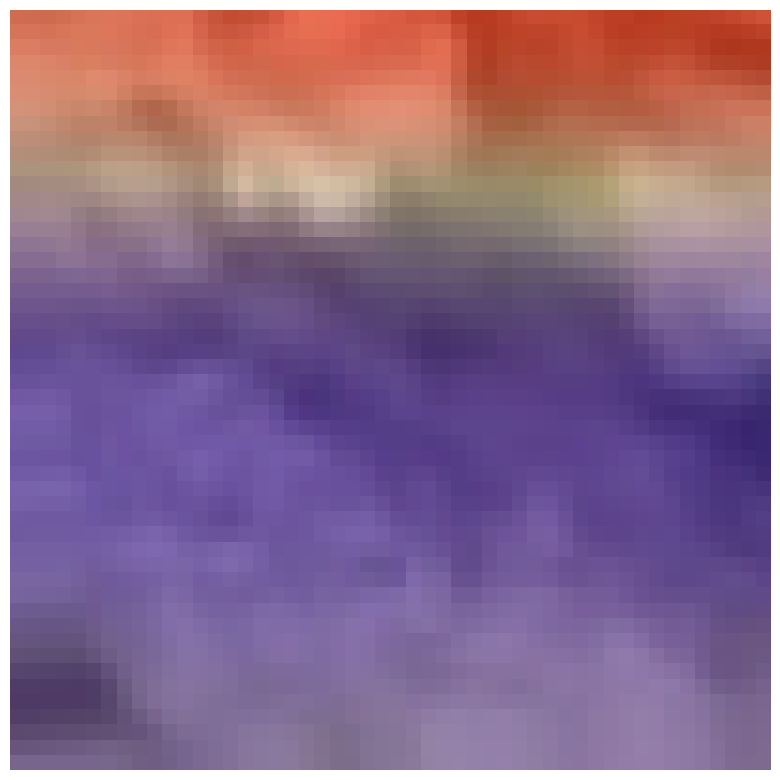

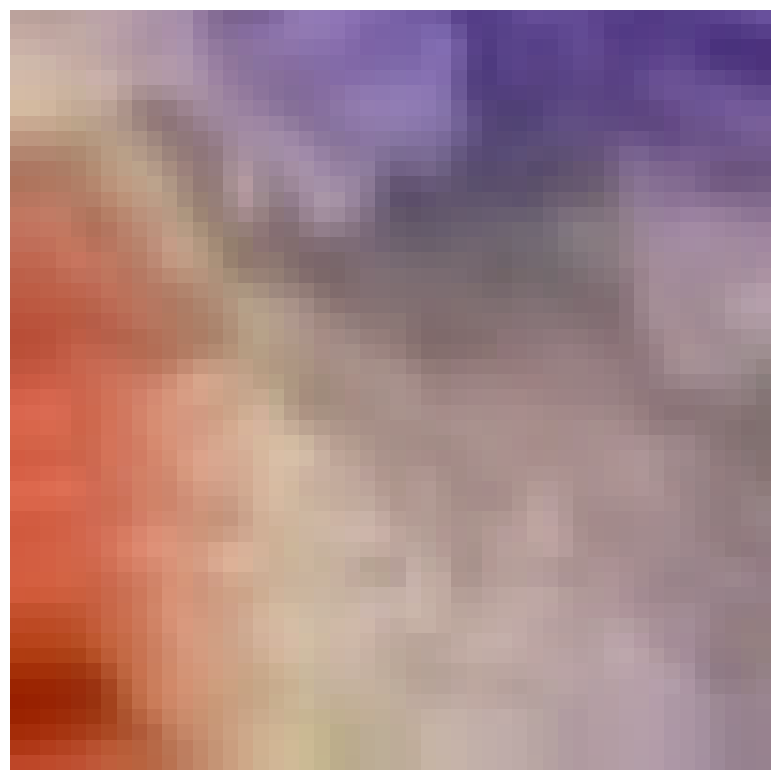

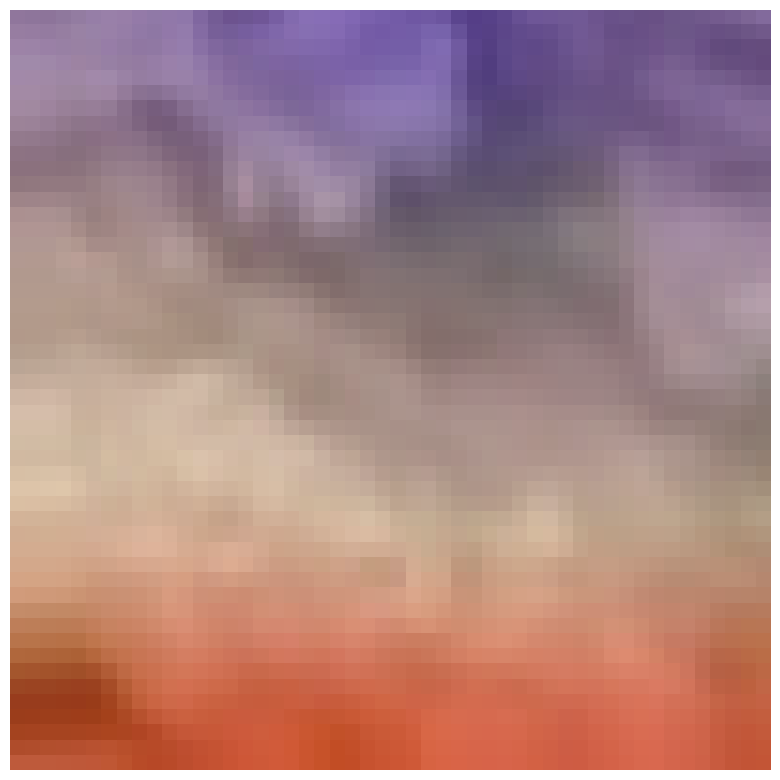

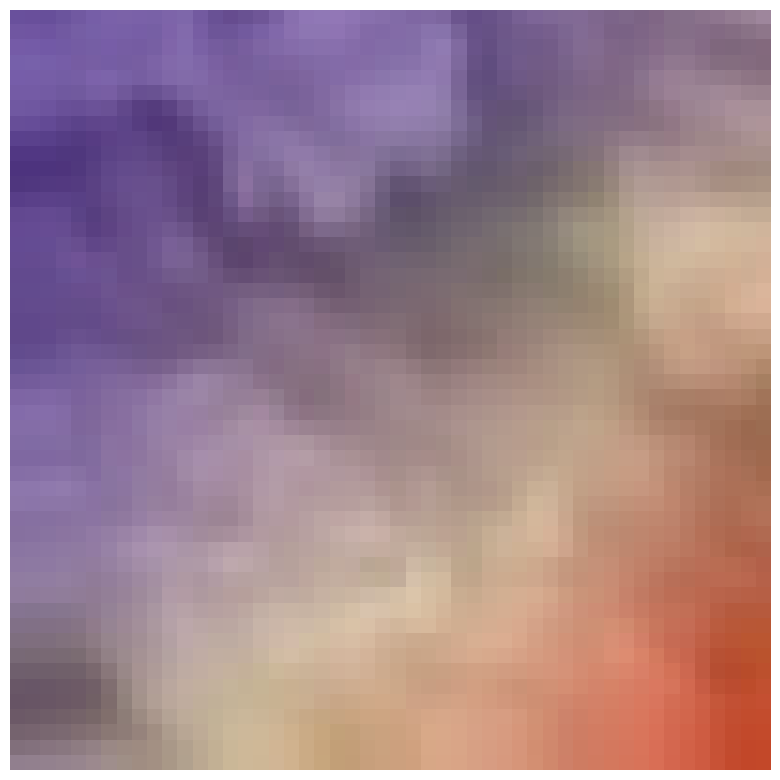

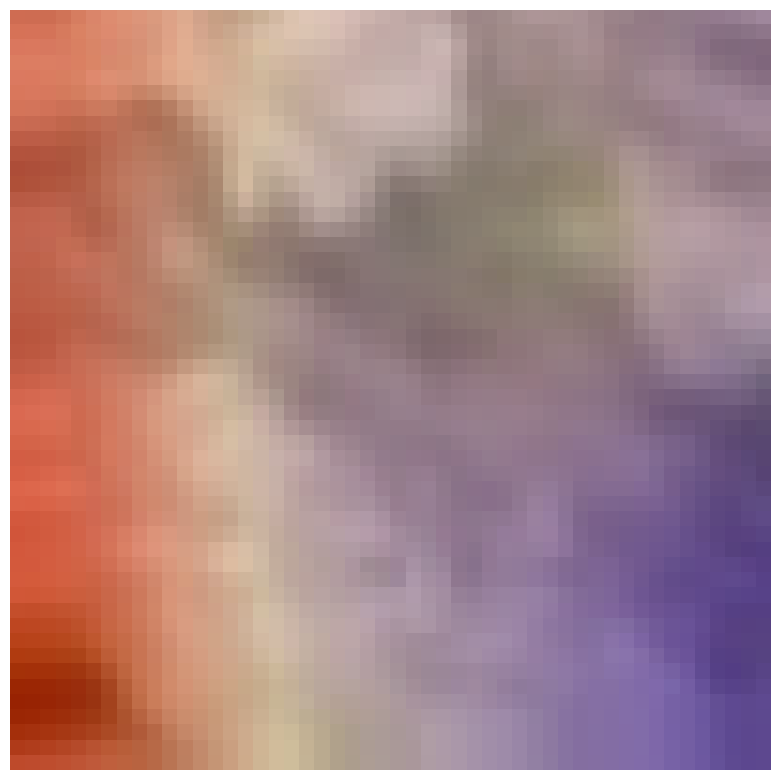

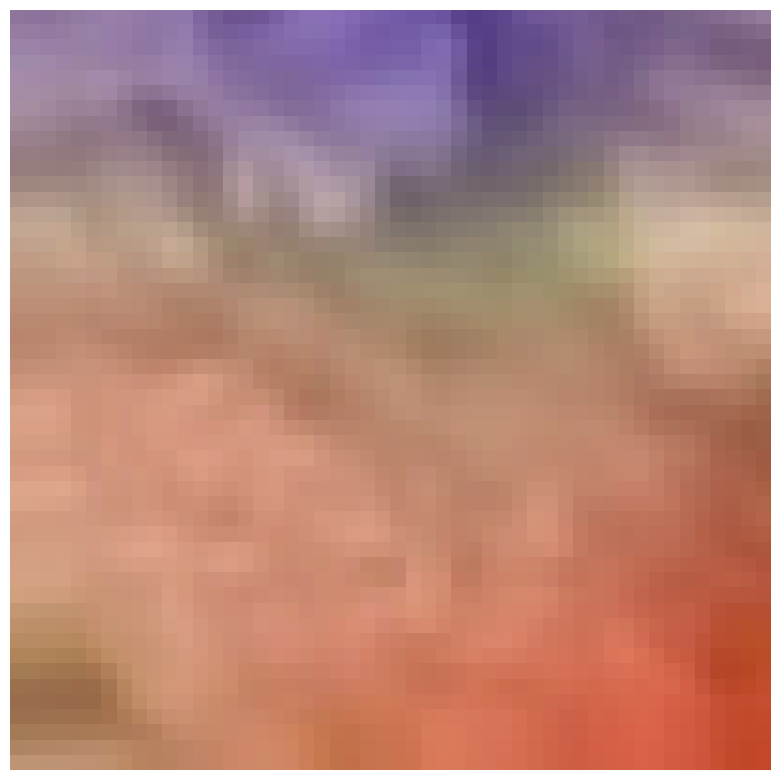

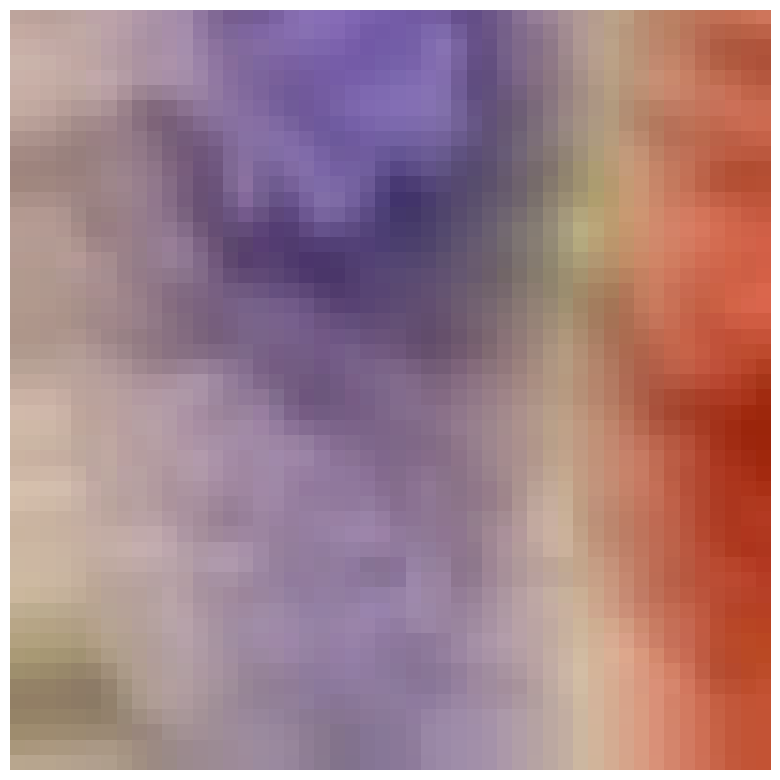

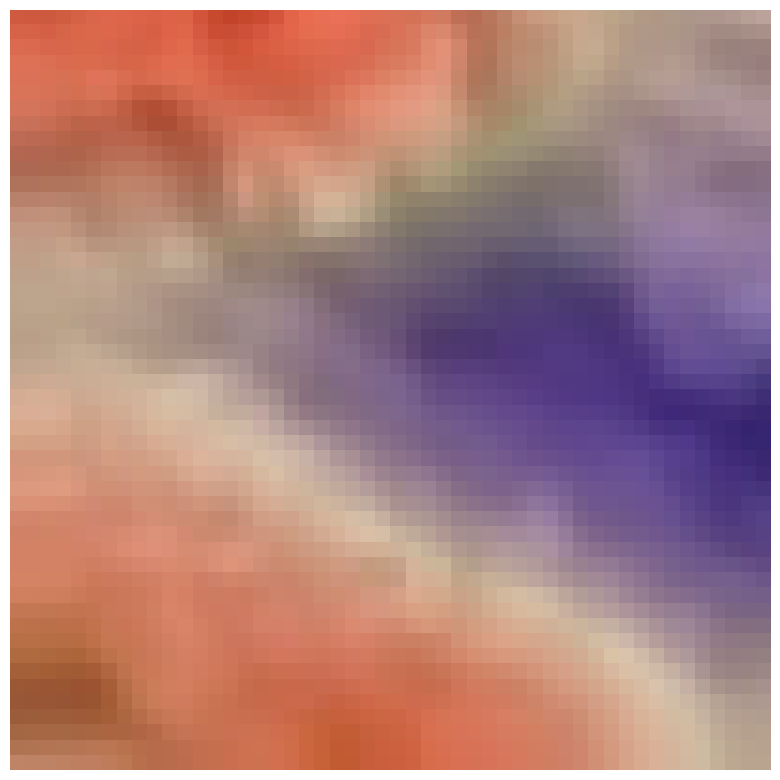

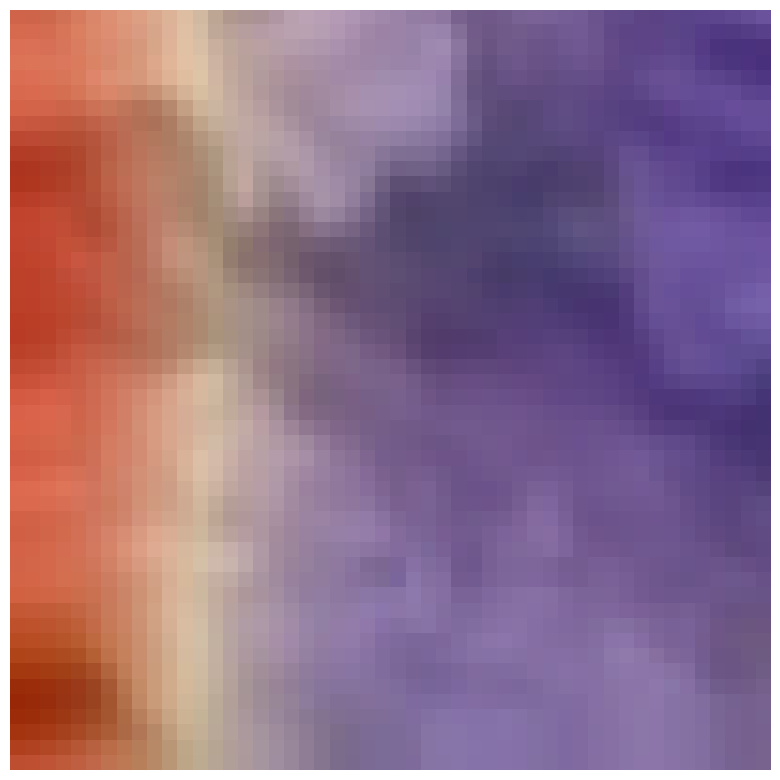

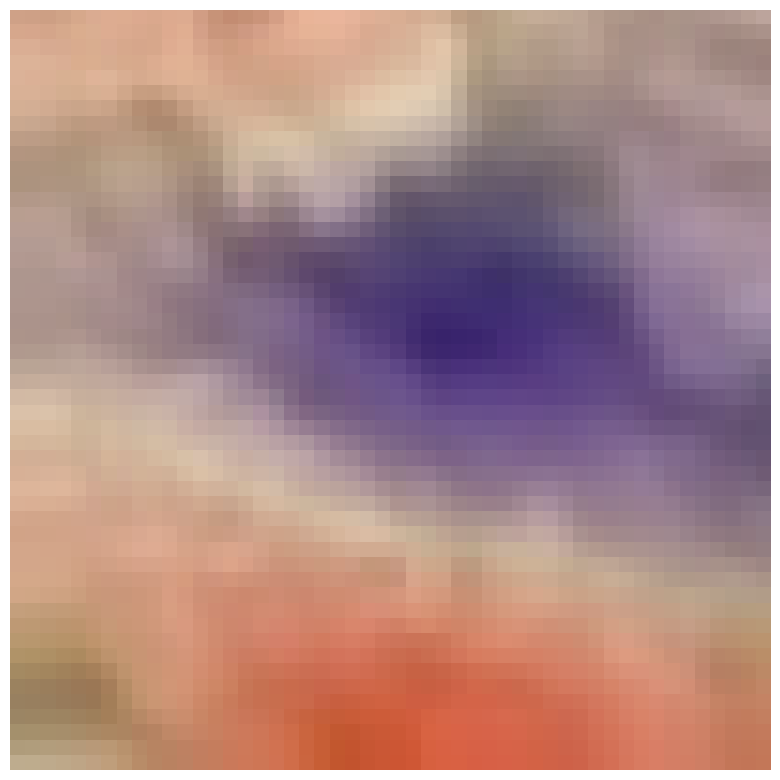

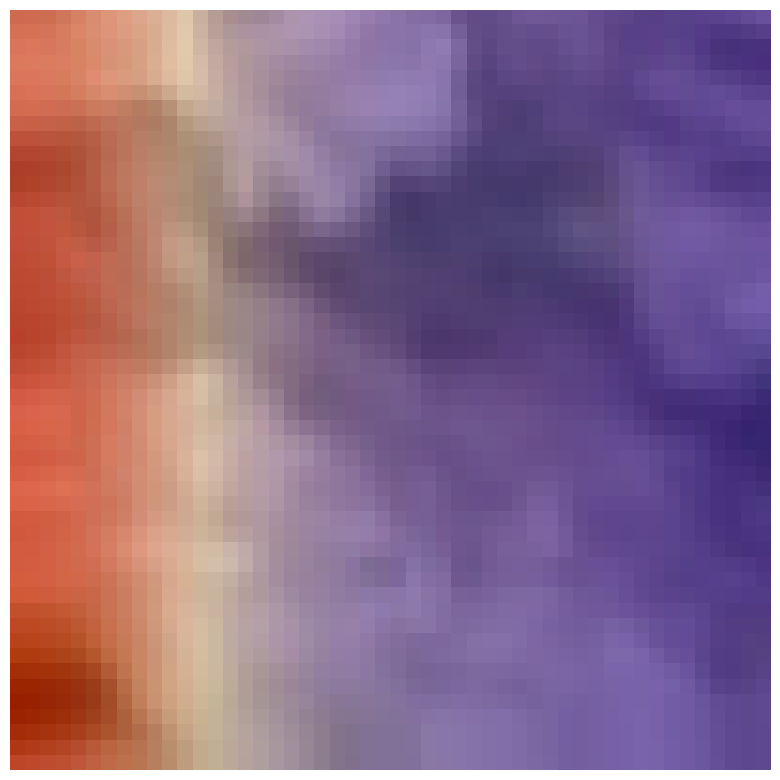

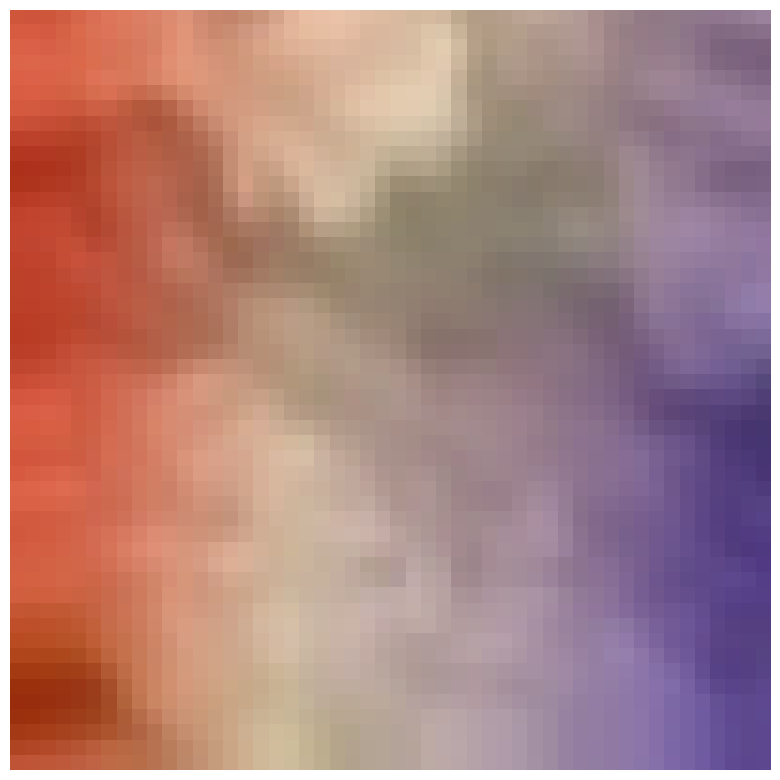

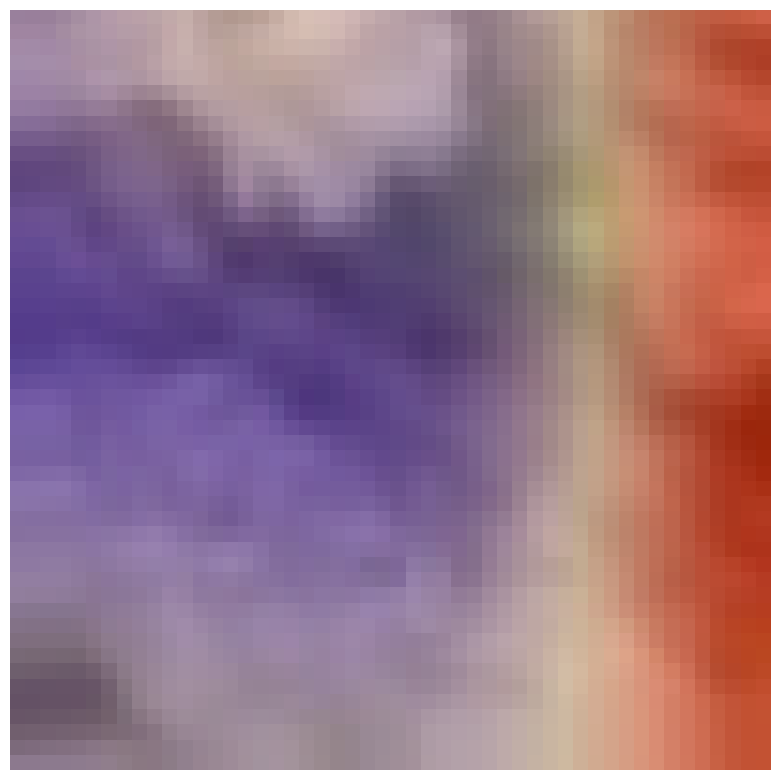

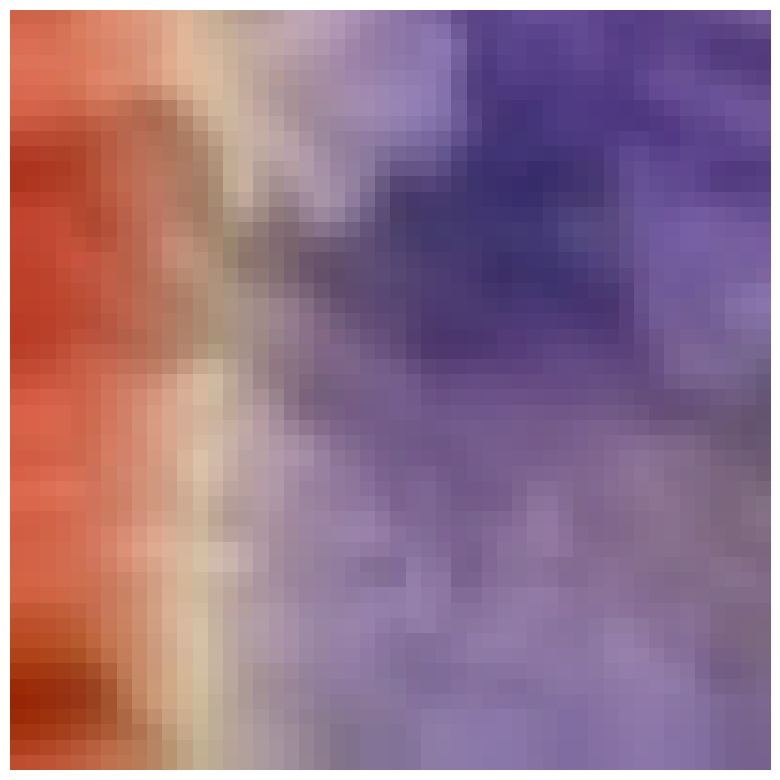

(-0.5, 49.5, 49.5, -0.5)

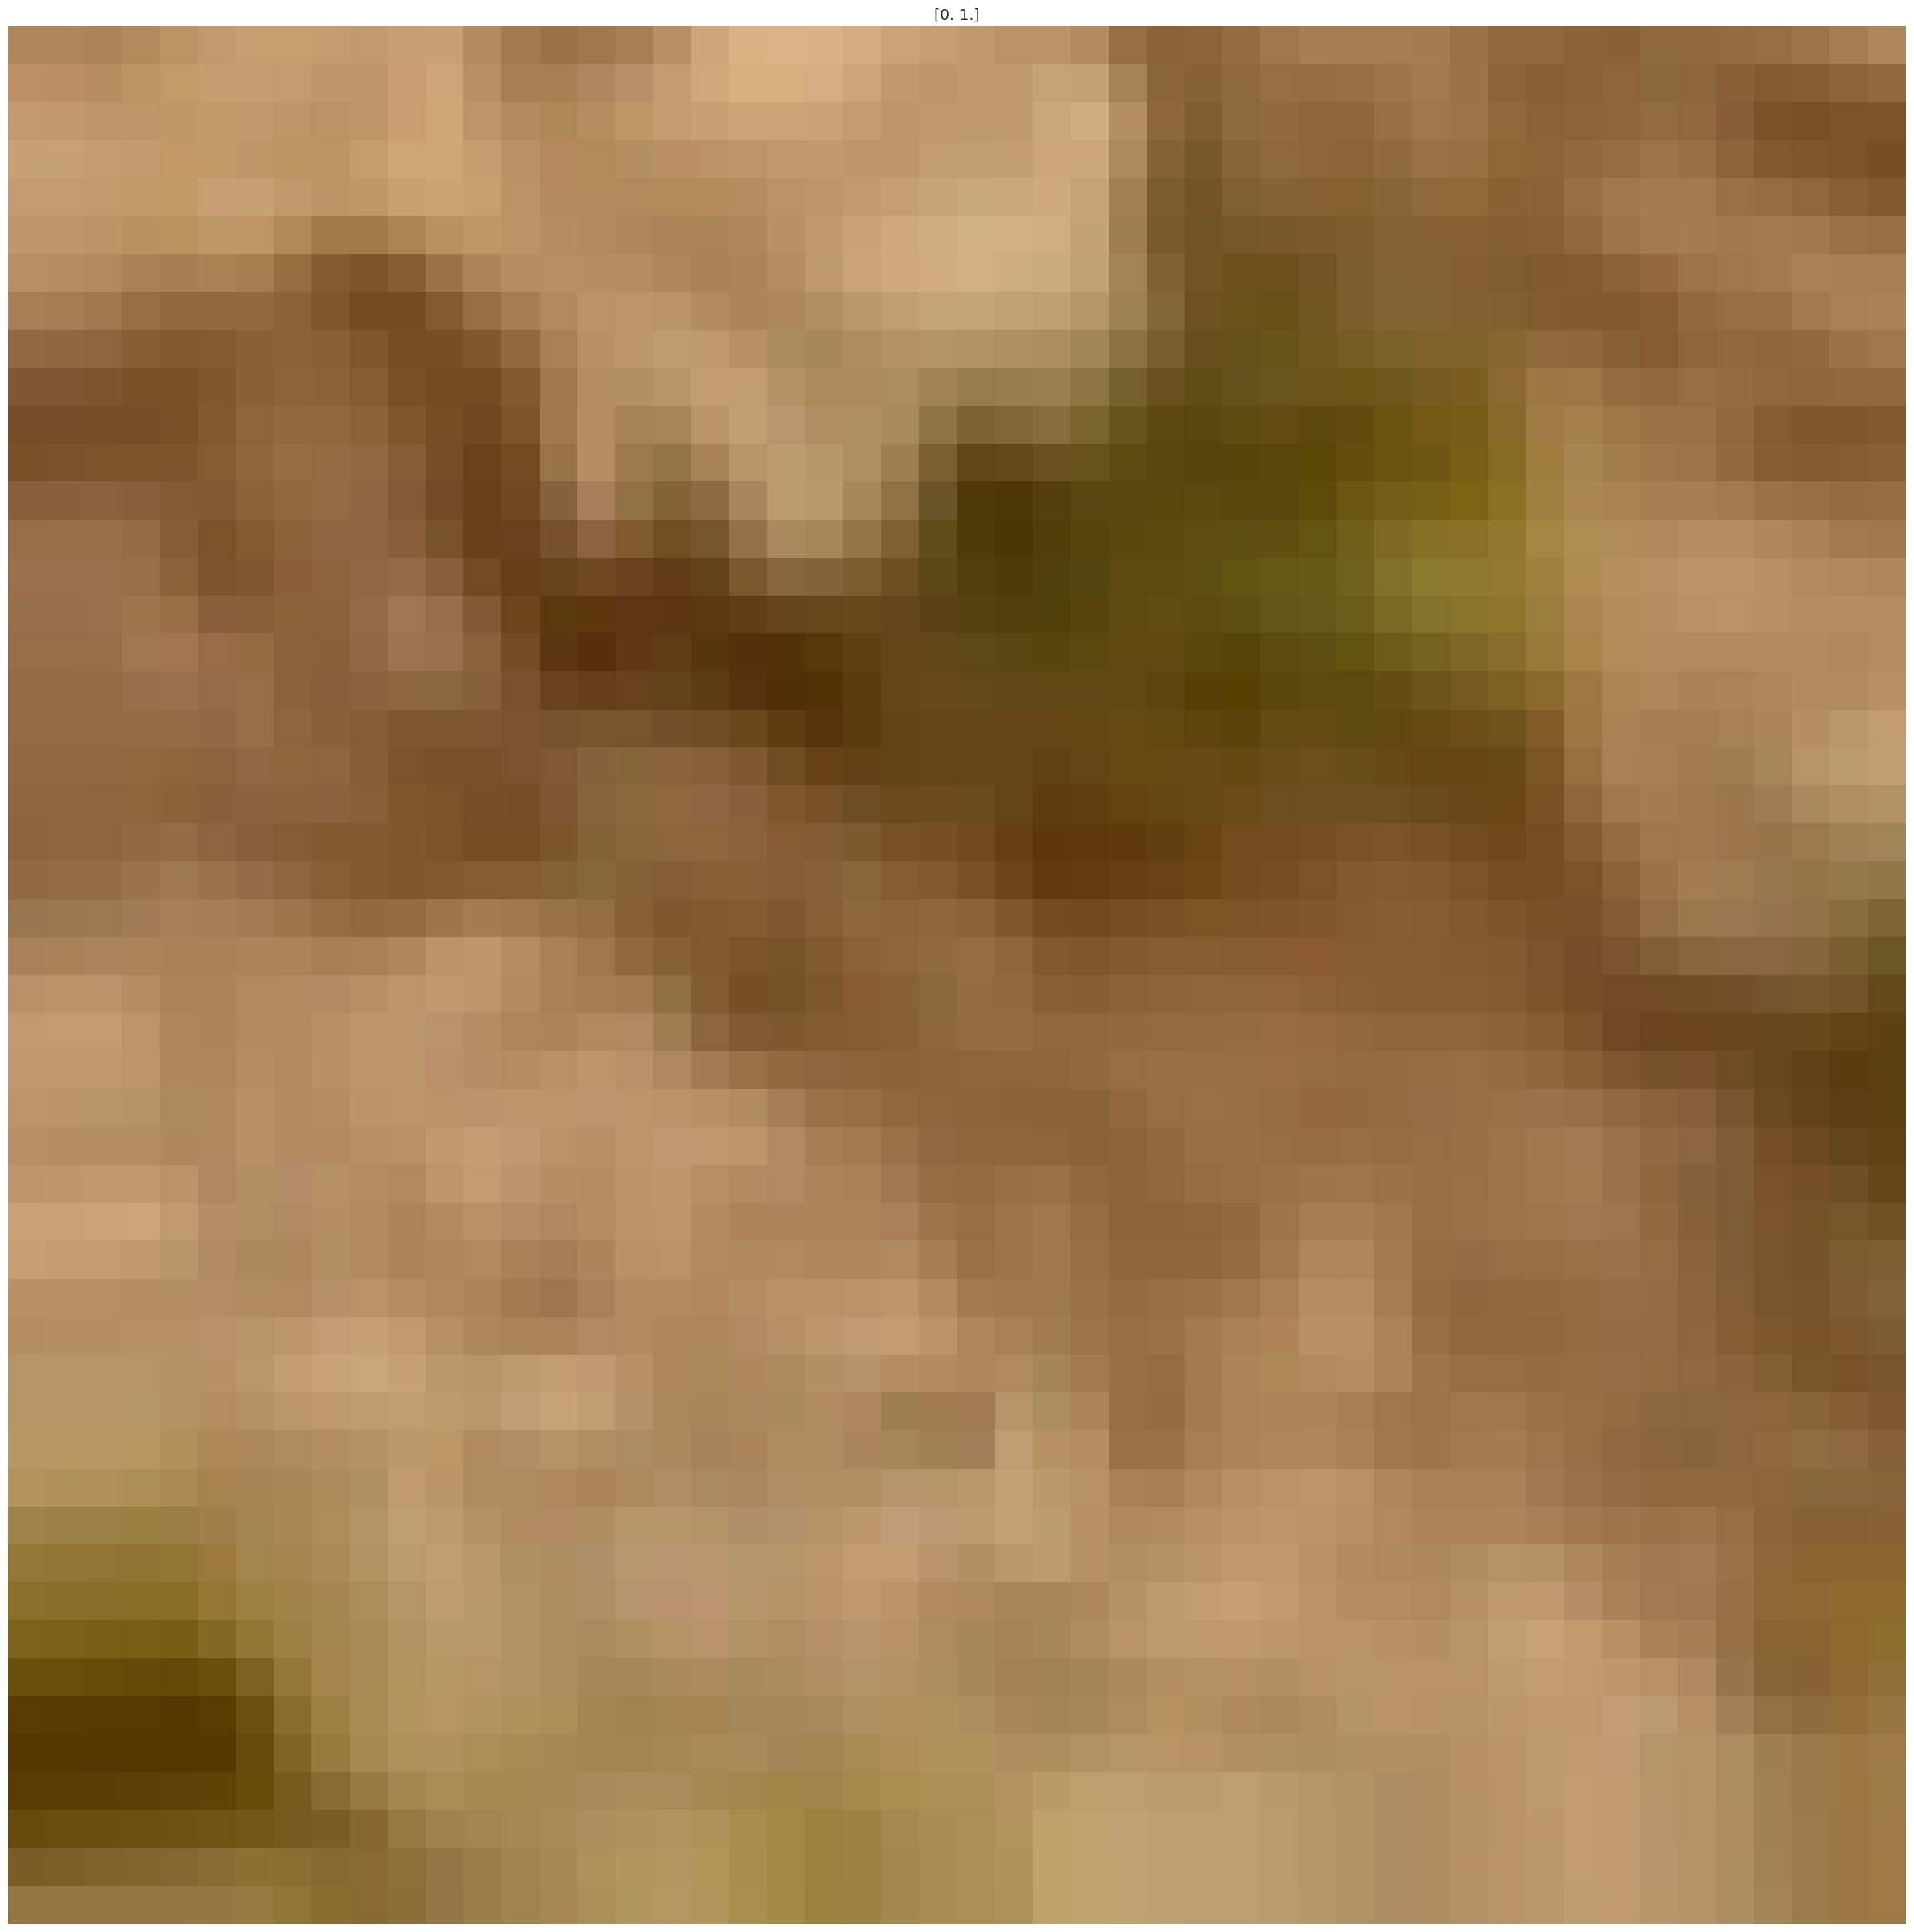

In [ ]:
# check onehot enconding and augmentation
n = 4
image_index = 6

# fig = plt.figure(figsize = (20,20))
heatmap = (ya * yf)[image_index,:,:,:].numpy()
heatmap-=heatmap.mean()
heatmap/=heatmap.std()

for i in range(yf.shape[-1]):
    fig.add_subplot(n, n, i+1)
    # sns.heatmap(heatmap[:,:,i], cbar = False)
    hm = HeatMap(wrong_predict[image_index].astype("uint8"),
                 heatmap[:,:,i])
    hm.plot(transparency = 0.4)

plt.figure(figsize = (30,30))
plt.title(right_labels[image_index])
plt.imshow(wrong_predict[image_index].astype("uint8"))
plt.axis("off")

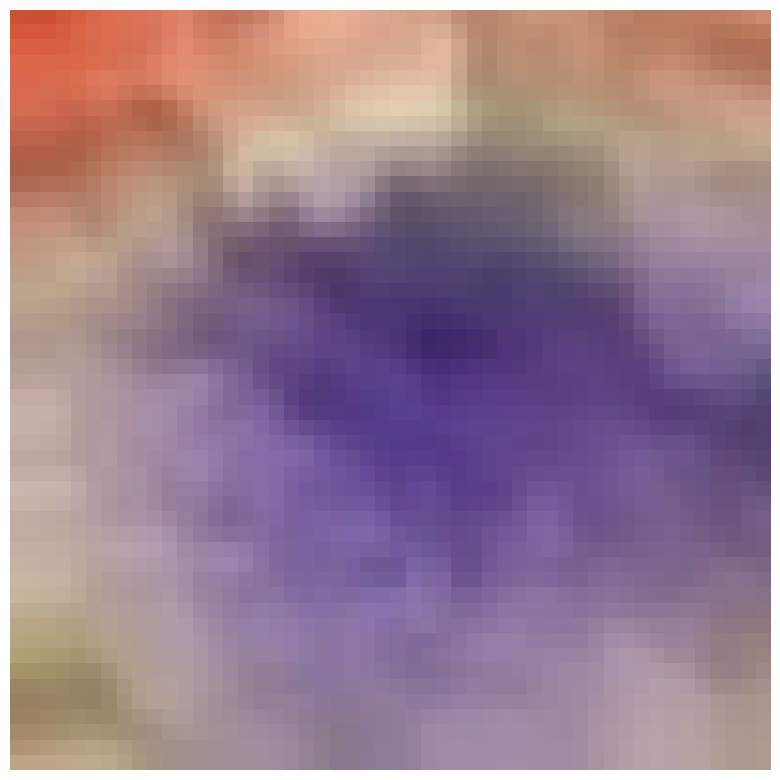

In [ ]:
# check onehot enconding and augmentation
n = 4
image_index = 6

# fig = plt.figure(figsize = (20,20))
heatmap = (ya * yf)[image_index,:,:,:].numpy()
heatmap-=heatmap.mean()
heatmap/=heatmap.std()

# sns.heatmap(heatmap[:,:,i], cbar = False)
hm = HeatMap(wrong_predict[image_index].astype("uint8"),
             np.sum(heatmap, axis = 2))
hm.plot(transparency = 0.4)